# Self-Driving Car Engineer Nanodegree - Udacity
** Rajesh Thallam | 18th July, 2017 ** 

## Project 1: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
# import basic packages
import os
import math

#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


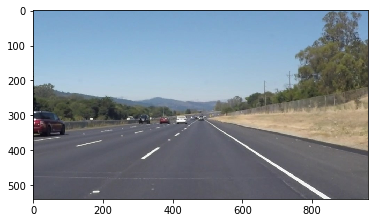

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

- `cv2.inRange()` for color selection  
- `cv2.fillPoly()` for regions selection  
- `cv2.line()` to draw lines on an image given endpoints  
- `cv2.addWeighted()` to coadd / overlay two images 
- `cv2.cvtColor()` to grayscale or change color 
- `cv2.imwrite()` to output images to file   
- `cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

**Created a python class for helper functions to make detection pipeline easier to call them<br><br>
Following are the helper functions built to help lane detection pipeline**
- <b>grayscale</b>: applies grayscale transformation on the image
- <b>canny</b>: applies canny transformation on the image
- <b>gaussian_blur</b>: applies gaussian noise kernel to blur the image
- <b>region_of_interest</b>: applies image mask on the image based on the region of interest expressed by edges and vertices
- <b>hough_lines</b>: returns image with hough lines
- <b>draw_lines</b>: draw lines on the image in-place. calls other helper functions to extrapolate lines
- <b>draw_right_line</b>: draw solid straight right line by determining best fit of segmented lines using linear regression
- <b>draw_left_line</b>: draw solid straight left line by determining best fit of segmented lines using linear regression
- <b>weighted_img</b>: combines two images based on the weights specified

In [52]:
class LaneDetectionHelper(object):
    """class to define lane detector"""
    def __init__(self,params):
        """
        initializing lane detector with default parameters
        """
        # size of kernel for gaussian blur algorithm
        self.kernel_size = params.get('kernel_size', 5)
        # canny edge detection low threshold
        self.low_threshold = params.get('low_threshold', 50)
        # canny edge detection high threshold
        self.high_threshold = params.get('high_threshold', 150)
        # distance resolution in pixels of the Hough grid
        self.rho = params.get('rho', 1)
        # angular resolution in radians of the Hough grid
        self.theta = params.get('theta', np.pi/180)
        # minimum number of votes (intersections in Hough grid cell)
        self.threshold = params.get('threshold', 1)
        # minimum number of pixels making up a line
        self.min_line_len = params.get('min_line_len', 10)
        # maximum gap in pixels between connectable line segments
        self.max_line_gap = params.get('max_line_gap', 1)
        # thickness of detected line
        self.line_thickness = params.get('line_thickness', 5)
        # color of detected line
        self.line_color = params.get('line_color', [255, 255, 255])
        # color of detected line
        self.line_slope_threshold = params.get('line_slope_threshold', [0.5, 1])
        # color of region of interest
        self.mask_color = params.get('mask_color', [255, 0, 0])
        # bottom offset for region of interest
        self.bottom_offset = params.get('bottom_offset', 55)
        # show just the lines detected without extrapolation
        self.extrapolate_flag = params.get('extrapolate_flag', True)
        # show the region of interest
        self.show_mask_flag = params.get('show_mask_flag', False)

    def grayscale(self, img):
        """Applies the Grayscale transform
        This will return an image with only one color channel
        but NOTE: to see the returned image as grayscale
        (assuming your grayscaled image is called 'gray')
        you should call plt.imshow(gray, cmap='gray')"""
        #return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Or use BGR2GRAY if you read an image with cv2.imread()
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    def canny(self, img, low_threshold, high_threshold):
        """Applies the Canny transform"""
        return cv2.Canny(img, low_threshold, high_threshold)

    def gaussian_blur(self, img, kernel_size):
        """Applies a Gaussian Noise kernel"""
        return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

    def region_of_interest(self, img, vertices):
        """
        Applies an image mask.

        Only keeps the region of the image defined by the polygon
        formed from `vertices`. The rest of the image is set to black.
        """
        # defining a blank mask to start with
        #mask = np.zeros(img.shape, dtype=np.uint8)
        mask = np.zeros_like(img)

        # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
        if len(img.shape) > 2:
            channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255

        # filling pixels inside the polygon defined by "vertices" with the fill color
        cv2.fillPoly(mask, vertices, ignore_mask_color)

        # returning the image only where mask pixels are nonzero
        masked_image = cv2.bitwise_and(img, mask)
        return masked_image

    def hough_lines(self, img, rho, theta, threshold, min_line_len, max_line_gap, vertices):
        """
        `img` should be the output of a Canny transform.

        Returns an image with hough lines drawn.
        """
        lines = cv2.HoughLinesP(
            img,
            rho,
            theta,
            threshold,
            np.array([]),
            minLineLength=min_line_len,
            maxLineGap=max_line_gap)

        line_img = np.zeros((*img.shape, 3), dtype=np.uint8)

        if self.show_mask_flag:
            cv2.fillPoly(line_img, vertices, self.mask_color)

        self.draw_lines(line_img, lines, vertices)
        return line_img

    def draw_lines(self, img, lines, vertices):
        """
        NOTE: this is the function you might want to use as a starting point once you want to
        average/extrapolate the line segments you detect to map out the full
        extent of the lane (going from the result shown in raw-lines-example.mp4
        to that shown in P1_example.mp4).

        Think about things like separating line segments by their
        slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
        line vs. the right line.  Then, you can average the position of each of
        the lines and extrapolate to the top and bottom of the lane.

        This function draws `lines` with `color` and `thickness`.
        Lines are drawn on the image inplace (mutates the image).
        If you want to make the lines semi-transparent, think about combining
        this function with the weighted_img() function below
        """

        left_lines = []
        right_lines = []
        threshold = self.line_slope_threshold

        for line in lines:
            for x1, y1, x2, y2 in line:
                # determine slope
                slope = ((y2-y1)/(x2-x1)) if (x2-x1) != 0 else 0

                # based on the slope isolate left and right lines
                # if extrapolation is turned on, solid lines will be drawn after extrapolation
                if self.extrapolate_flag:
                    if (
                            (threshold[0] < abs(slope) < threshold[1]) and
                            np.sign(slope) < 0 and
                            not np.isnan(slope) and
                            not np.isinf(slope)
                    ):
                        right_lines.append(line)
                    if (
                            (threshold[0] < abs(slope) < threshold[1]) and
                            np.sign(slope) > 0 and
                            not np.isnan(slope) and
                            not np.isinf(slope)
                    ):
                        left_lines.append(line)
                # if extrapolation is turned off, segmented lines will be drawn
                else:
                    cv2.line(img, (x1, y1), (x2, y2), self.line_color, self.line_thickness)

        # if extrapolation is turned on, draw solid lines separately
        if self.extrapolate_flag:
            if left_lines:
                self.draw_left_line(img, left_lines, vertices)

            if right_lines:
                self.draw_right_line(img, right_lines, vertices)

    def draw_left_line(self, img, lines, vertices):
        """
        draws left line of the detected lane
        """
        # get the y coordinate of beginning of all lines
        all_y1 = np.array([line[0][1] for line in lines])

        # from the segmented set of lines find best fit of straight solid line
        # similar to linear regression fitting points to best line
        X = np.append(
            np.array([line[0][0] for line in lines]),
            np.array([line[0][2] for line in lines])
        )
        Y = np.append(
            np.array([line[0][1] for line in lines]),
            np.array([line[0][3] for line in lines])
        )
        
        # get slope and y-intercept
        m, b = np.polyfit(X, Y, 1)

        # determine extrapolated or solid line coordinates
        y1 = min(np.min(all_y1), int(np.mean(all_y1)))
        x1 = int((y1 - b) / m)
        y2 = vertices[0][3][1]
        x2 = int((y2 - b) / m)

        # draw line on the image
        cv2.line(img, (x1, y1), (x2, y2), self.line_color, self.line_thickness)

    def draw_right_line(self, img, lines, vertices):
        """
        draws right line of the detected lane
        """
        # get the y coordinate of beginning of all lines
        all_y2 = np.array([line[0][3] for line in lines])

        # from the segmented set of lines find best fit of straight solid line
        # similar to linear regression fitting points to best line
        X = np.append(
            np.array([line[0][0] for line in lines]),
            np.array([line[0][2] for line in lines])
        )
        Y = np.append(
            np.array([line[0][1] for line in lines]),
            np.array([line[0][3] for line in lines])
        )

        # get slope and y-intercept
        m, b = np.polyfit(X, Y, 1)

        # determine extrapolated or solid line coordinates
        y2 = min(np.min(all_y2), int(np.mean(all_y2)))
        x2 = int((y2 - b) / m)
        y1 = vertices[0][0][1]
        x1 = int((y1 - b) / m)

        # draw line on the image
        cv2.line(img, (x1, y1), (x2, y2), self.line_color, self.line_thickness)
        
    def weighted_img(self, initial_img, img, alpha=0.8, beta=1., gamma=0.):
        """
        `img` is the output of the hough_lines(), An image with lines drawn on it.
        Should be a blank image (all black) with lines drawn on it.

        `initial_img` should be the image before any processing.

        The result image is computed as follows:

        initial_img * alpha + img * beta + gamma
        NOTE: initial_img and img must be the same shape!
        """
        return cv2.addWeighted(initial_img, alpha, img, beta, gamma)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

**
Created a python class with lane detection pipeline and processing functions. These functions are used throughout the notebook to process an image or a video or a directory of images. Parameters can be changed in the `process_image` function. Tuning was carried out by changing parameters in this function.**<br><br>

**Following are the functions**
- <b>process_image</b>: process a specific image to detect lines by passing parameters as required. Function returns an image with detected lines
- <b>process_image_dir</b>: process a directory of images (colored only). Each input image is processed and plotted with detected lines and saved into output directory
- <b>lane_detection_pipeline</b>: main pipeline that calls helper functions and detects lines and returns result image with detected lines
- <b>process_video</b>: process a specific video or clip of video and detect lines with the video. Function saves the output video with detected lines in output directory

In [41]:
class LaneDetectionPipeline(object):
    """
    utility class to call lane detection pipeline given image or video
    """

    def process_image_dir(self, in_dir, save_image_flag=False, out_dir="./test_images/results"):
        """
        process all images in a directory
        """
        src_dir = os.listdir(in_dir)

        if save_image_flag:
            if not os.path.exists(out_dir):
                os.mkdir(out_dir)
        
        cntr_image = 0

        in_img_col  = np.arange(1,2*len(src_dir),2)
        out_img_col = in_img_col + 1
        
        for img in src_dir:
            image = mpimg.imread(in_dir + img)
            result = self.process_image(image)

            fig, ax = plt.subplots(figsize=(15,60))

            plt.subplot(len(src_dir),2,in_img_col[cntr_image])
            plt.title(img)
            plt.imshow(image)

            plt.subplot(len(src_dir),2,out_img_col[cntr_image])
            plt.title(img + ' with detected lines')
            plt.imshow(result)
            
            plt.tight_layout()
            plt.show()

            if save_image_flag:
                out_img = out_dir + img
                mpimg.imsave(out_img, result)
                print('successfully detected lines: in = {} and out = {}'.format(img, out_img))

            cntr_image += 1

    def process_image(self, image):
        """
        process image to find lines
        # NOTE: The output you return should be a color image (3 channel) for processing video below
        # TODO: put your pipeline here,
        # you should return the final output (image where lines are drawn on lanes)
        """

        params = {
            'kernel_size': 5,
            'low_threshold': 50,
            'high_threshold': 150,
            'rho': 1,
            'theta': np.pi/180,
            'threshold': 1,
            'min_line_len': 10,
            'max_line_gap': 1,
            'line_thickness': 8,
            'line_color': [255, 0, 0],
            'line_slope_threshold': [0.45, 1],
            'mask_color': (255, 0, 0),
            'extrapolate_flag': True,
            'show_mask_flag': False,
            'bottom_offset': 55
        }
        result = self.lane_detection_pipeline(image, params)
        
        return result

    def process_video(self, in_file, out_file):
        """
        process image to find lines
        """
        in_video = VideoFileClip(in_file)
        out_video = in_video.fl_image(self.process_image)
        out_video.write_videofile(out_file, audio=False)

        
    def lane_detection_pipeline(self, image, params):
        """
        main method or pipeline to detect lane given an image
        """
        
        # lane detection pipeline
        ldp = LaneDetectionHelper(params)
        
        # convert image from RGB to gray
        grayed = ldp.grayscale(image)
        # apply gaussian filter to remove the sharp edges
        blurred_gray = ldp.gaussian_blur(grayed, ldp.kernel_size)
        # apply canny edge detection algorithm
        edges = ldp.canny(blurred_gray, ldp.low_threshold, ldp.high_threshold)
        
        # chosing four sided polygon to mask instead of a triangle
        imshape = image.shape
        img_height = imshape[0]
        img_width = imshape[1]

        # [bottom-left, top-left, top-right, bottom-right]
        vertice_weights = np.array([(1, 1), (0.448, 0.575), (0.516, 0.575), (0.948, 1)])
        vertices = np.array([
            [
                (ldp.bottom_offset, img_height) * vertice_weights[0],
                (img_width, img_height) * vertice_weights[1],
                (img_width, img_height) * vertice_weights[2],
                (img_width, img_height) * vertice_weights[3]
            ]
        ], dtype=np.int32)

        masked_edges = ldp.region_of_interest(edges, vertices)

        # applying hough transformation
        hough_img = ldp.hough_lines(
            masked_edges,
            ldp.rho,
            ldp.theta,
            ldp.threshold,
            ldp.min_line_len,
            ldp.max_line_gap,
            vertices)

        result = ldp.weighted_img(image, hough_img, alpha=1., beta=0.8, gamma=0.)

        return result

**This section details lane detection pipeline used for processing images, which will also be reused during processing of video.**<br><br>

- Convert RGB image to grayscale image to help detect lines based on the brightness of lines
- Apply Gaussian blur or kernel (filter) to smooth the image in order to remove the noise
- Apply canny edge detection on the blurred gray image to detect edges based on the intensity gradients in the image
- Identify region of interest in the image to detect the lane lines and mask the rest
- Apply Hough transformation to detect the straight lines in the image within the region of interest
- Isolate left and right lines from the detected lines based on sign of the slope i.e. negative (right) or positive (left) and if slope falls within a threshold
- For each set of left and right lines, determine the best fitting single solid striaght line similar to linear regression
- From the best fit line, determine end points of the line and draw the lines on image
- Save and/or display images with detected lines

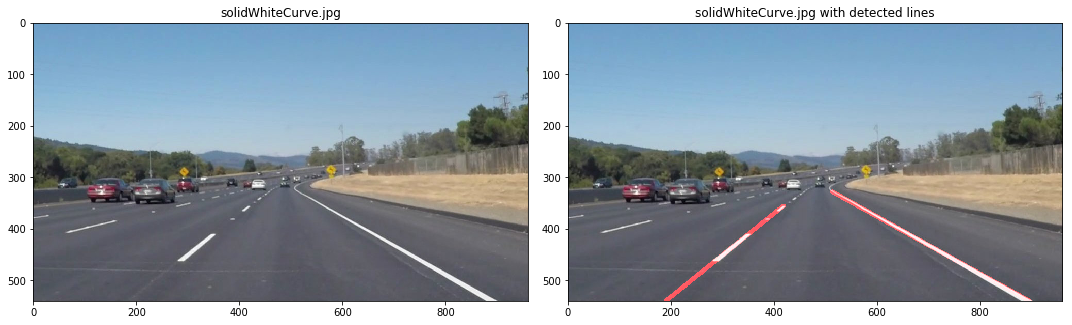

successfully detected lines: in = solidWhiteCurve.jpg and out = test_images_output/solidWhiteCurve.jpg


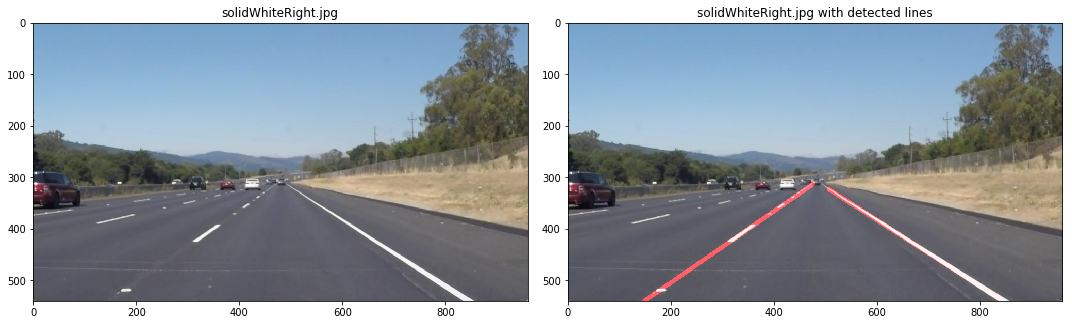

successfully detected lines: in = solidWhiteRight.jpg and out = test_images_output/solidWhiteRight.jpg


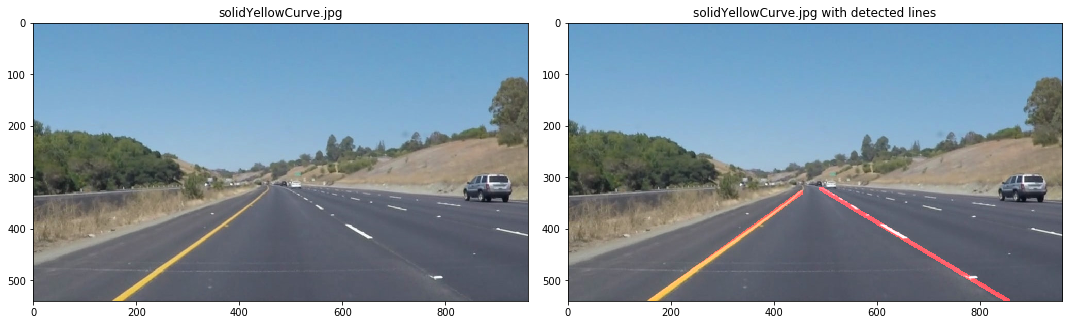

successfully detected lines: in = solidYellowCurve.jpg and out = test_images_output/solidYellowCurve.jpg


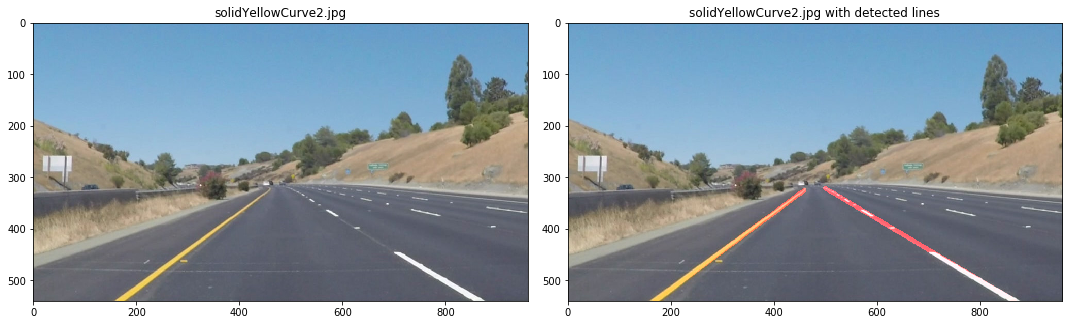

successfully detected lines: in = solidYellowCurve2.jpg and out = test_images_output/solidYellowCurve2.jpg


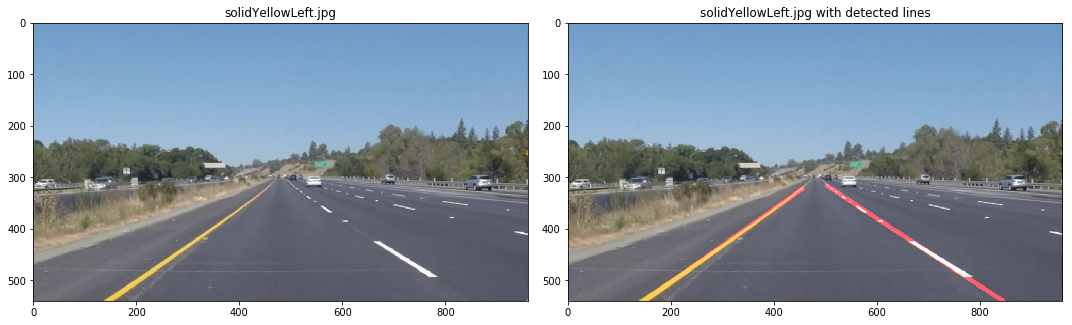

successfully detected lines: in = solidYellowLeft.jpg and out = test_images_output/solidYellowLeft.jpg


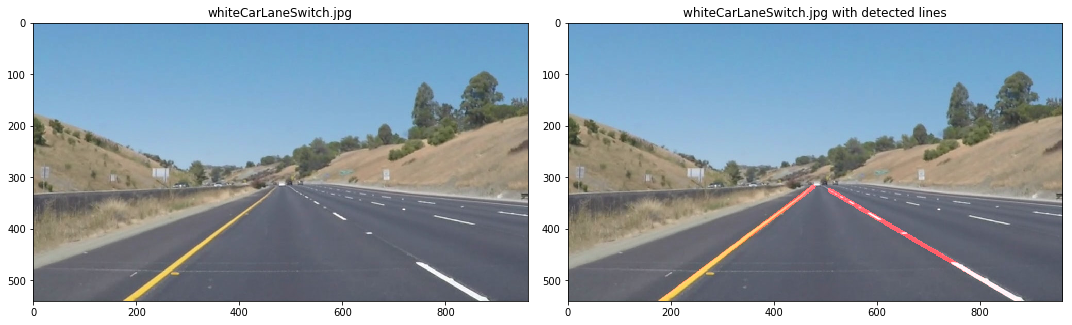

successfully detected lines: in = whiteCarLaneSwitch.jpg and out = test_images_output/whiteCarLaneSwitch.jpg


In [42]:
image_lane_detector = LaneDetectionPipeline()
image_lane_detector.process_image_dir('test_images/', True, 'test_images_output/')

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [8]:
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

white_input  = "test_videos/solidWhiteRight.mp4"
white_output = 'test_videos_output/solidWhiteRight.mp4'

video_lane_detector = LaneDetectionPipeline()
%time video_lane_detector.process_video(white_input, white_output)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:20<00:00, 10.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.57 s, sys: 171 ms, total: 3.74 s
Wall time: 23 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [10]:
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)

yellow_input = 'test_videos/solidYellowLeft.mp4'
yellow_output = 'test_videos_output/solidYellowLeft.mp4'

video_lane_detector = LaneDetectionPipeline()
%time video_lane_detector.process_video(yellow_input, yellow_output)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [01:02<00:00,  9.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 10.5 s, sys: 380 ms, total: 10.9 s
Wall time: 1min 5s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [12]:
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)

challenge_input = 'test_videos/challenge.mp4'
challenge_output = 'test_videos_output/challenge.mp4'

video_lane_detector = LaneDetectionPipeline()
%time video_lane_detector.process_video(challenge_input, challenge_output)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:45<00:00,  5.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 6.51 s, sys: 357 ms, total: 6.86 s
Wall time: 51.4 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

***

** Appendix | Testing **

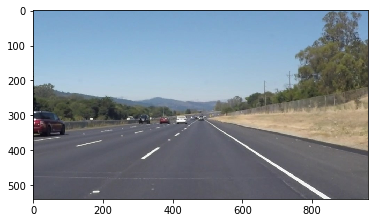

In [48]:
image = mpimg.imread('./test_images/solidWhiteRight.jpg')
plt.imshow(image)

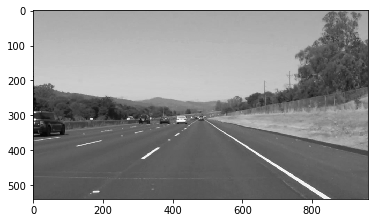

In [60]:
# lane detection pipeline
params = {
    'kernel_size': 5,
    'low_threshold': 50,
    'high_threshold': 150,
    'rho': 1,
    'theta': np.pi/180,
    'threshold': 1,
    'min_line_len': 10,
    'max_line_gap': 1,
    'line_thickness': 8,
    'line_color': [255, 0, 0],
    'line_slope_threshold': [0.45, 1],
    'mask_color': (255, 0, 0),
    'extrapolate_flag': True,
    'show_mask_flag': False,
    'bottom_offset': 55
}
ldp = LaneDetectionHelper(params)

# convert image from RGB to gray
grayed = ldp.grayscale(image)
plt.imshow(grayed, cmap='gray')

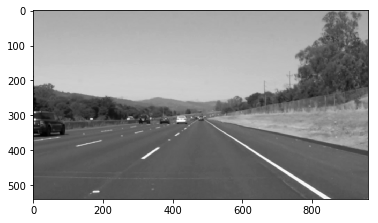

In [54]:
# apply gaussian filter to remove the sharp edges
blurred_gray = ldp.gaussian_blur(grayed, ldp.kernel_size)
plt.imshow(blurred_gray, cmap='gray')

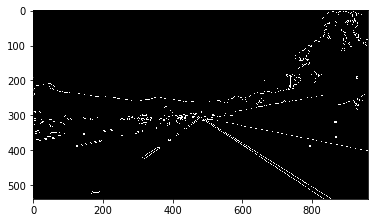

In [55]:
# apply canny edge detection algorithm
edges = ldp.canny(blurred_gray, ldp.low_threshold, ldp.high_threshold)
plt.imshow(edges, cmap='gray')

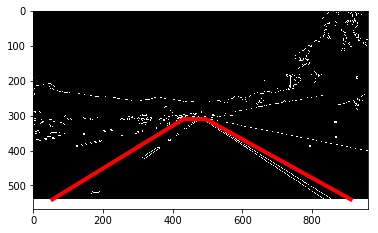

In [81]:
# chosing four sided polygon to mask instead of a triangle
imshape = image.shape
img_height = imshape[0]
img_width = imshape[1]

# [bottom-left, top-left, top-right, bottom-right]
vertice_weights = np.array([(1, 1), (0.448, 0.575), (0.516, 0.575), (0.948, 1)])
vertices = np.array([
    [
        (ldp.bottom_offset, img_height) * vertice_weights[0],
        (img_width, img_height) * vertice_weights[1],
        (img_width, img_height) * vertice_weights[2],
        (img_width, img_height) * vertice_weights[3]
    ]
], dtype=np.int32)

masked_edges = ldp.region_of_interest(edges, vertices)
plt.imshow( edges, cmap='gray')
x = vertices[..., 0][0]
y = vertices[..., 1][0]
plt.plot(x, y, 'r-', lw=4)
plt.show()

In [71]:
vertices[...,0]

array([[ 55, 430, 495, 910]], dtype=int32)

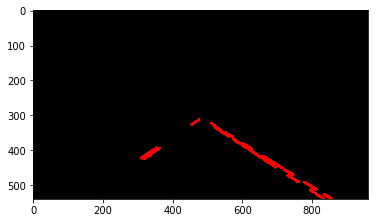

In [59]:
# applying hough transformation
hough_img = ldp.hough_lines(
    masked_edges,
    ldp.rho,
    ldp.theta,
    ldp.threshold,
    ldp.min_line_len,
    ldp.max_line_gap,
    vertices)
plt.imshow( hough_img, cmap='gray')

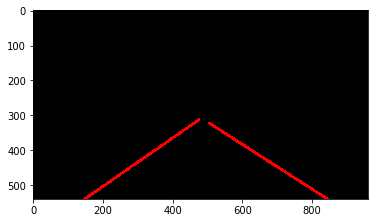

In [61]:
# applying hough transformation
hough_img = ldp.hough_lines(
    masked_edges,
    ldp.rho,
    ldp.theta,
    ldp.threshold,
    ldp.min_line_len,
    ldp.max_line_gap,
    vertices)
plt.imshow( hough_img, cmap='gray')

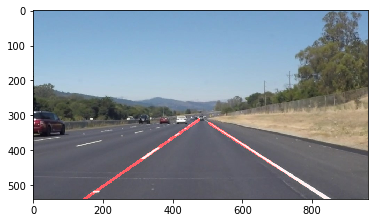

In [63]:
result = ldp.weighted_img(image, hough_img, alpha=1., beta=0.8, gamma=0.)
plt.imshow( result, cmap='gray')